In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

### Explore and clean the data if needed.

In [3]:
df_heart=pd.read_csv('C:/Users/Dell/Downloads/heart - heart.csv')
df_heart.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df_heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [5]:
df_heart.duplicated().sum()

0

### Perform a train-test split on your data.

In [7]:
x = df_heart.drop(columns='HeartDisease')
y = df_heart['HeartDisease']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=42)

### Use a column transformer to scale the numeric features and one-hot encode the categorical features.

In [8]:
categoric_select = make_column_selector(dtype_include='object')
numeric_select = make_column_selector(dtype_include='number')

scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')

numeric_tuple = ('num', scaler, numeric_select)
categoric_tuple = ('cat', ohe, categoric_select)

processor = ColumnTransformer([numeric_tuple, categoric_tuple], remainder='passthrough')

In [9]:
xtrain_processed = processor.fit_transform(xtrain)
xtest_processed = processor.transform(xtest)

### Define your base sequential model.

In [14]:
#Include the number of features in your input layer.
#Use the correct activation function and the correct number of neurons for your output layer.
#Compile your model with the correct loss function and an optimizer (‘adam’ is a fine choice)
#Include a validation split when fitting the model.
#Plot your model’s training history.
#Evaluate your models with appropriate metrics.

In [11]:
model = keras.Sequential()
model.add(Dense(10, input_dim=xtrain_processed.shape[1],
          activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'bce', metrics = 'accuracy')

In [12]:
history = model.fit(xtrain_processed, ytrain,validation_split=.2,epochs = 10)

Epoch 1/10
18/18 [==============================] - 1s 19ms/step - loss: 0.6587 - accuracy: 0.6364 - val_loss: 0.6368 - val_accuracy: 0.7246
Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.7491 - val_loss: 0.6102 - val_accuracy: 0.7536
Epoch 3/10
18/18 [==============================] - 0s 3ms/step - loss: 0.5850 - accuracy: 0.7982 - val_loss: 0.5843 - val_accuracy: 0.7971
Epoch 4/10
18/18 [==============================] - 0s 4ms/step - loss: 0.5495 - accuracy: 0.8018 - val_loss: 0.5565 - val_accuracy: 0.8043
Epoch 5/10
18/18 [==============================] - 0s 3ms/step - loss: 0.5150 - accuracy: 0.8145 - val_loss: 0.5278 - val_accuracy: 0.8188
Epoch 6/10
18/18 [==============================] - 0s 4ms/step - loss: 0.4804 - accuracy: 0.8273 - val_loss: 0.5025 - val_accuracy: 0.8333
Epoch 7/10
18/18 [==============================] - 0s 3ms/step - loss: 0.4493 - accuracy: 0.8364 - val_loss: 0.4796 - val_accuracy: 0.8333
Epoch 8/10
18/18 [=

(<Figure size 600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'accuracy'}>], dtype=object))

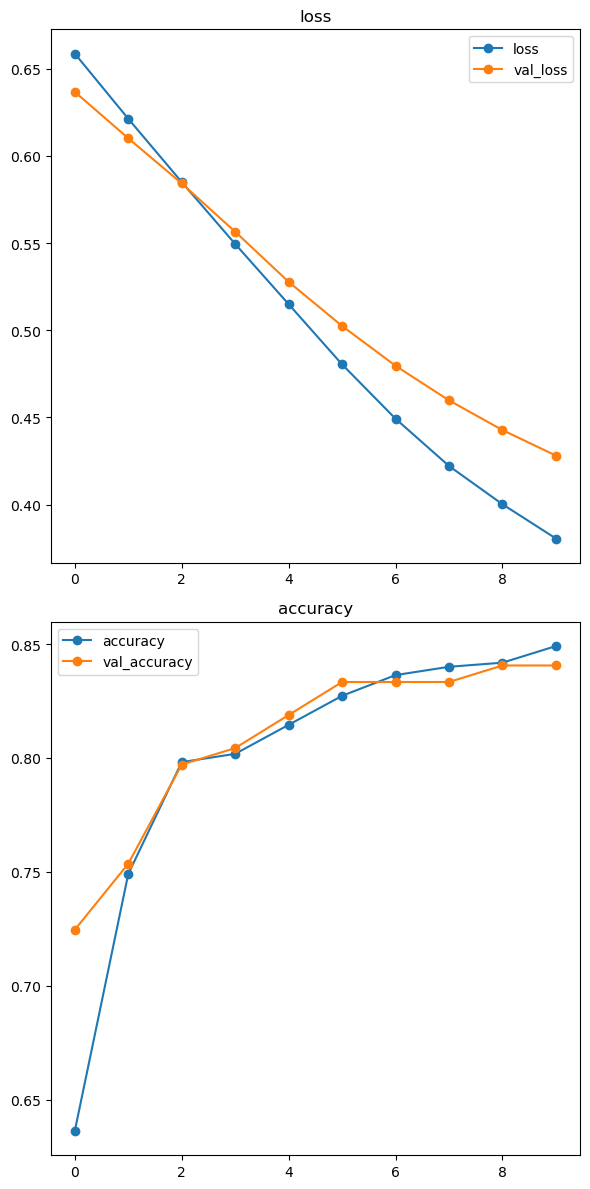

In [13]:
plot_history(history)

In [16]:
result = model.evaluate(xtest_processed, ytest,return_dict=True)
result

8/8 [==============================] - 0s 1ms/step - loss: 0.4048 - accuracy: 0.8261


{'loss': 0.40476372838020325, 'accuracy': 0.8260869383811951}

8/8 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        98
           1       0.85      0.84      0.85       132

    accuracy                           0.83       230
   macro avg       0.82      0.82      0.82       230
weighted avg       0.83      0.83      0.83       230



<Axes: >

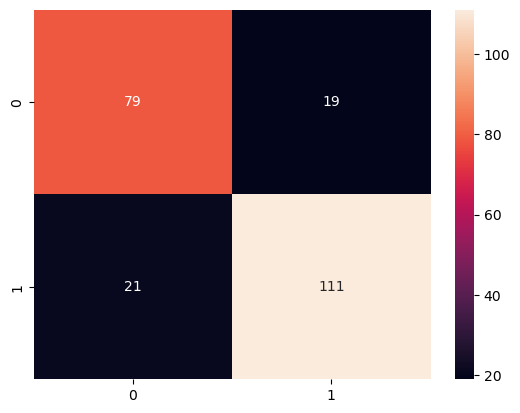

In [17]:
test_prediction = model.predict(xtest_processed).round()
print(classification_report(ytest, test_prediction))
confusion_matrix = confusion_matrix(ytest, test_prediction)
sns.heatmap(confusion_matrix, annot=True, fmt ='g')